## Lect 1_Part 2 Simple LPP Problem using PyPSA

### Powerplants: Coal, gas, Renewables LPP

In [11]:
import pypsa
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# Create a new PyPSA network
network = pypsa.Network()
network.set_snapshots(range(1))  # Solve for a single time snapshot

# Define the buses (electricity demand)
network.add("Bus", "electricity_bus", carrier="electricity")

# Add generators (power plants) with defined emissions rate per MWh generated
network.add("Generator", "Coal", bus="electricity_bus", p_nom_extendable=False, marginal_cost=30, p_nom=60, carrier="coal")
network.add("Generator", "Gas", bus="electricity_bus", p_nom_extendable=False, marginal_cost=60, p_nom=80, carrier="gas")
network.add("Generator", "PV", bus="electricity_bus", p_nom_extendable=True, marginal_cost=0, p_nom_max=40)
network.add("Generator", "Wind", bus="electricity_bus", p_nom_extendable=True, marginal_cost=0, p_nom_max=70)

network.madd(
    "Carrier",
    names=["coal","gas","pv","wind"],
    color=["black","darkslategray","gold","lightseagreen"],
    co2_emissions=[0.8,0.4,0,0],
)

# Add global CO2 emissions constraint for the entire network
network.add(
    "GlobalConstraint",
    "emission_limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=60,  # Total CO2 emissions limit in tons
)

# Add load data (electricity demand)
network.add("Load", "electricity_load", bus="electricity_bus", p_set=200)

# Optimize the network to minimize the total cost
network.optimize(solver_name="highs")

# Print the results
print(network.generators_t.p)  # Power output per generator
print(f"Total Cost of Electricity Generation: {network.objective} €")
print(f"Total CO2 Emissions: {network.global_constraints.constant} tons")
# Individual emissions
emissions_ind = (network.generators_t.p/ network.generators.efficiency* network.generators.carrier.map(network.carriers.co2_emissions))
print(f"Total Emissions: {emissions_ind.sum().sum()} tons")

Index(['electricity_bus'], dtype='object', name='Bus')
Index(['electricity_bus'], dtype='object', name='Bus')
c:\Users\suhas\anaconda3\Lib\site-packages\linopy\common.py:147: UserWarning:

coords for dimension(s) ['Generator'] is not aligned with the pandas object. Previously, the indexes of the pandas were ignored and overwritten in these cases. Now, the pandas object's coordinates are taken considered for alignment.

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.06s
INFO:linopy.solvers:Log file at C:\Users\suhas\AppData\Local\Temp\highs.log
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 6 primals, 18 duals
Objective: 3.60e+03
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Generator  Coal   Gas    PV  Wind
snapshot                         
0          60.0  30.0  40.0  70.0
Total Cost of Electricity Generation: 3600.0 €
Total CO2 Emissions: GlobalConstraint
emission_limit    60.0
Name: constant, dtype: float64 tons
Total Emissions: 60.0 tons


In [3]:
network.statistics()

Optimal Capacity  Installed Capacity  Supply  Withdrawal  \
Generator -                110.0                 0.0   110.0         0.0   
          coal              60.0                60.0    10.0         0.0   
          gas               80.0                80.0    80.0         0.0   
Load      -                  0.0                 0.0     0.0       200.0   

                Energy Balance Transmission  Capacity Factor  Curtailment  \
Generator -              110.0          0.0         1.000000          0.0   
          coal            10.0          0.0         0.166667         50.0   
          gas             80.0          0.0         1.000000          0.0   
Load      -             -200.0          0.0              NaN          0.0   

                Capital Expenditure  Operational Expenditure  Revenue  \
Generator -                     0.0                      0.0   9900.0   
          coal                  0.0                    300.0    900.0   
          gas                   0.0                   4800.0   7200.0   
Load      -                     0.0                      0.0 -18000.0   

                Market Value  
Generator -             90.0  
          coal          90.0  
          gas           90.0  
Load      -              NaN

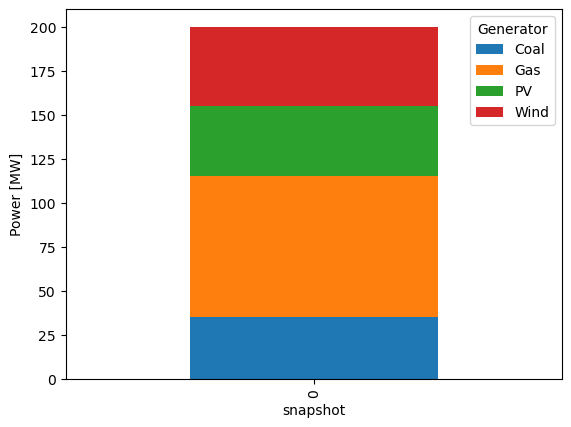

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
network.generators_t.p.plot(kind="bar", stacked=True, ax=ax)
plt.ylabel("Power [MW]")
plt.show()

<Axes: xlabel='Generator', ylabel='Total generation MW'>

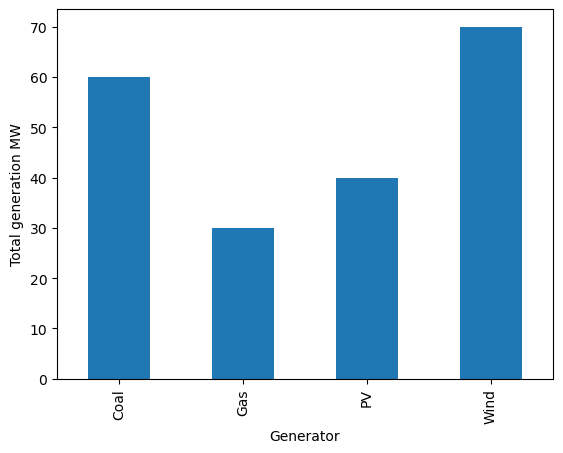

In [12]:
network.generators_t.p.sum().plot.bar(ylabel="Total generation MW")